In [8]:
import numpy as np
from DSSStartup import DSSStartup
from setInfo import *
from getInfo import *
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time
#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0

#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0, 0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5, 0,0,0,0,0,0,0,0,0,0,0,0,0])
#PercentHacked = np.array([0,0,0,0,0, .1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node

Delay_VoltageSampling = np.array([0,0,0,0,0, 10,10,10,10,10,10,10,10,10,10,10,10,10, 0,0,0,0,0,0,0,0,0,0,0,0,0]) 
Delay_VBPCurveShift =   np.array([0,0,0,0,0, 60,60,60,60,60,60,60,60,60,60,60,60,60, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Appropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')

#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='C:\\feeders\\testpvnum10\\';
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time) ,4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds

#this is to permutate Load and Generation samples on nodes
"""temp = np.copy(Load[:, 0:Number_of_Inverters])
Load[:, 0:Number_of_Inverters] = Load[:, Number_of_Inverters:Number_of_Inverters*2]
Load[:, Number_of_Inverters:Number_of_Inverters*2] = temp
temp = np.copy(Generation[:, 0:Number_of_Inverters])
Generation[:, 0:Number_of_Inverters] = Generation[:, Number_of_Inverters:Number_of_Inverters*2]
Generation[:, Number_of_Inverters:Number_of_Inverters*2] = temp"""

#Create noise vector
Noise = np.empty([TotalTimeSteps, TotalLoads])
for node in range(TotalLoads):
    Noise[:,node] = np.random.randn(TotalTimeSteps) 

#Add noise to loads
for node in range(TotalLoads):
    Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

if NoiseMultiplyer > 0:
    print('Load Interpolation has been done. Noise was added to the load profile.') 
else:
    print('Load Interpolation has been done. No Noise was added to the load profile.') 
    
MaxGenerationPossible = np.max(Generation, axis = 0)
sbar = MaxGenerationPossible

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
Reading Data for Pecan Street is done.
Starting Interpolation...
Load Interpolation has been done. No Noise was added to the load profile.


In [9]:
############################################################
############################################################
#### Function for simulation################################
############################################################
############################################################

def inverter_qp_injection(counter, Vk, Vkm1, gammakm1, solar_irr, VBP, Sbar, dv, T=1, lpf=1):
    pk = 0
    qk = 0
    c = 0
    q_avail = 0

    solar_range = 5

    Vmagk = abs(Vk)
    Vmagkm1 = abs(Vkm1)
    gammakcalc = (T*lpf*(Vmagk + Vmagkm1) - (T*lpf - 2)*gammakm1)/(2 + T*lpf)

    if counter % dv == 0:
        gammakused = gammakcalc
    else :
        gammakused = gammakm1

    if solar_irr < solar_range:
        pk = 0
        qk = 0
    elif solar_irr >= solar_range:
        if gammakused <= VBP[2]:
            pk = -solar_irr
            q_avail = (Sbar**2 - pk**2)**(1/2)
            if gammakused <= VBP[0]:
                qk = 0
            elif gammakused > VBP[0] and gammakused <= VBP[1]:
                c = q_avail/(VBP[1] - VBP[0])
                qk = c*(gammakused - VBP[0])
            else:
                qk = q_avail
        elif gammakused > VBP[2] and gammakused < VBP[3]:
            d = -solar_irr/(VBP[3] - VBP[2])
            pk = -(d*(gammakused - VBP[2]) + solar_irr)
            qk = (Sbar**2 - pk**2)**(1/2)
        elif gammakused >= VBP[3]:
            qk = Sbar
            pk = 0
    return qk,pk, gammakused
    
def voltage_observer(vk, vkm1, psikm1, epsilonkm1, ykm1, f_hp=1, f_lp=0.1, gain=1e5, T=1):
    Vmagk = abs(vk)
    Vmagkm1 = abs(vkm1)
    psik = (Vmagk - Vmagkm1 - (f_hp*T/2-1)*psikm1)/(1+f_hp*T/2)
    epsilonk = gain*(psik**2)
    yk = (T*f_lp*(epsilonk + epsilonkm1) - (T*f_lp - 2)*ykm1)/(2 + T*f_lp)
    return yk, psik, epsilonk

def adaptive_control(delay, vk, vkmdelay, ukmdelay, thresh, yk):
    if (yk > thresh):
        uk = delay/2*k * ( vk**2 + vkmdelay**2 ) + ukmdelay
    else:
        uk = ukmdelay
    return uk

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-4996.9497690653625
--- 44.94734597206116 seconds ---


D:\Apps\Anacoda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


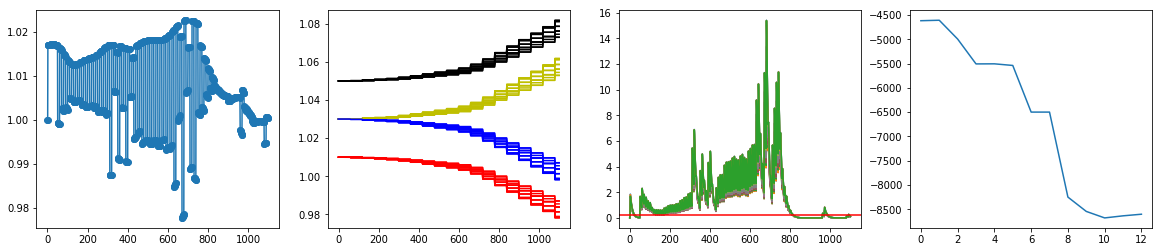

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-2629.6463951999685
--- 40.97172164916992 seconds ---


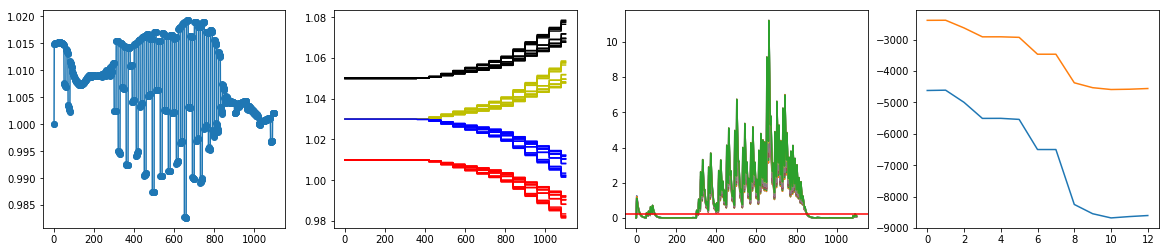

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-2629.6463951999685
--- 38.986913442611694 seconds ---


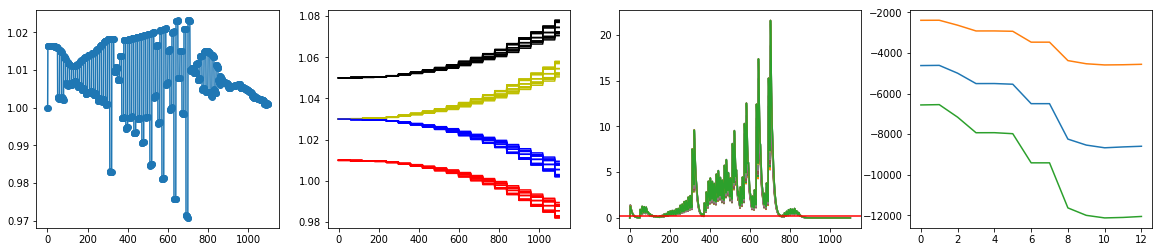

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-29.05268058172378
--- 38.840835094451904 seconds ---


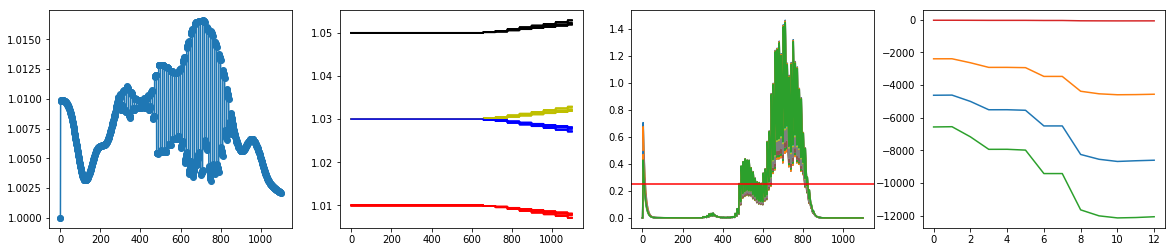

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-29.05268058172378
--- 41.73599433898926 seconds ---


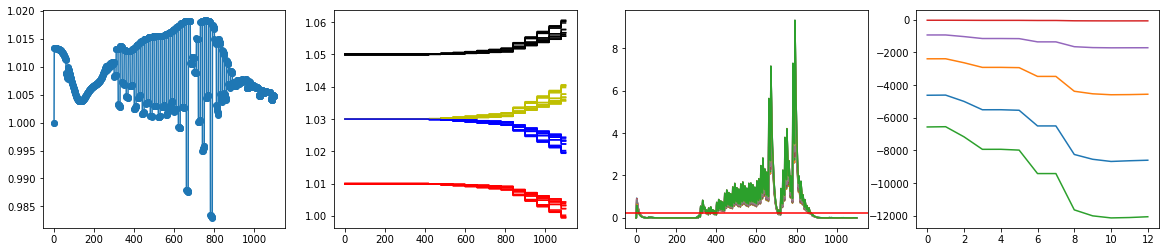

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-29.05268058172378
--- 42.34544324874878 seconds ---


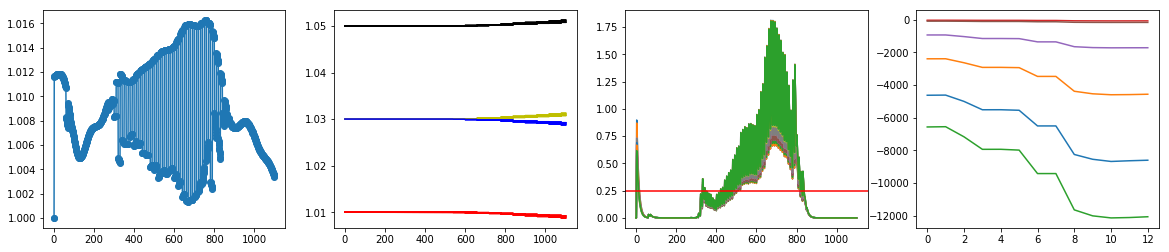

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-29.05268058172378
--- 39.01050519943237 seconds ---


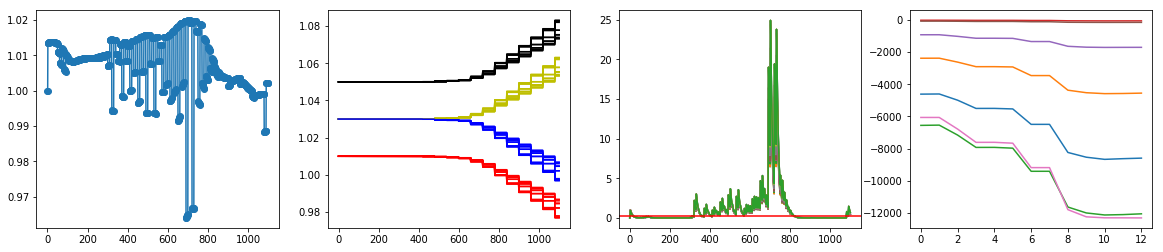

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-29.05268058172378
--- 43.508864879608154 seconds ---


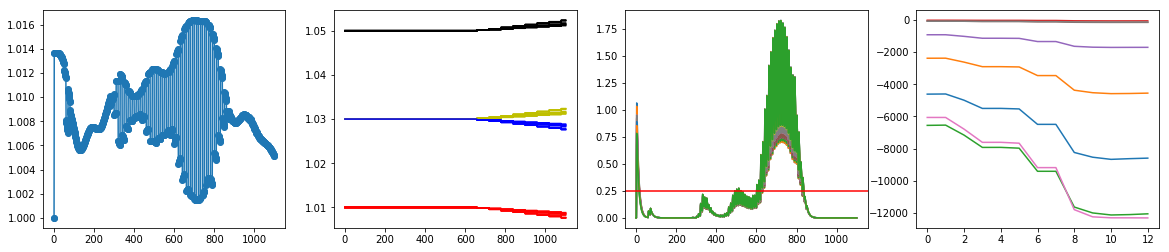

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-29.05268058172378
--- 39.3217568397522 seconds ---


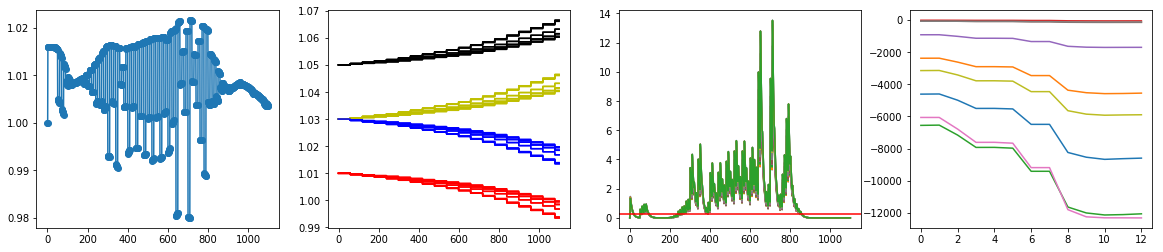

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
-29.05268058172378
--- 39.149250984191895 seconds ---


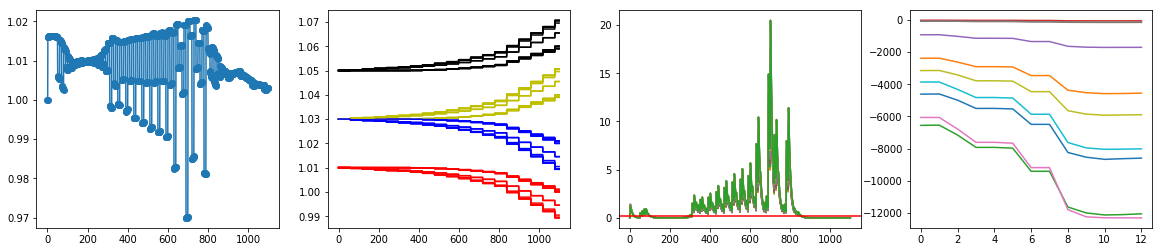

In [10]:

totalPoints = [[],[],[],[],[],[],[],[],[],[],[],[],[]]

for ep in range(10):
    #this is for permutate the Load and Generation profile on each node
    Load = np.random.permutation(Load.T).T
    Generation = np.random.permutation(Generation.T).T

    #this is to permutate the Load and Generation profile
    #temp = np.copy(Load[:, 0:Number_of_Inverters])
    #Load[:, 0:Number_of_Inverters] = Load[:, Number_of_Inverters:Number_of_Inverters*2]
    #Load[:, Number_of_Inverters:Number_of_Inverters*2] = temp
    #temp = np.copy(Generation[:, 0:Number_of_Inverters])
    #Generation[:, 0:Number_of_Inverters] = Generation[:, Number_of_Inverters:Number_of_Inverters*2]
    #Generation[:, Number_of_Inverters:Number_of_Inverters*2] = temp

    #Create noise vector
    Noise = np.empty([TotalTimeSteps, TotalLoads])
    for node in range(TotalLoads):
        Noise[:,node] = np.random.randn(TotalTimeSteps) 

    #Add noise to loads
    for node in range(TotalLoads):
        Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

    if NoiseMultiplyer > 0:
        print('Load Interpolation has been done. Noise was added to the load profile.') 
    else:
        print('Load Interpolation has been done. No Noise was added to the load profile.') 

    MaxGenerationPossible = np.max(Generation, axis = 0)
    sbar = MaxGenerationPossible
    
    start_time = time.time()
    #########################################################
    ################### RESTART OPENDSS #####################
    #########################################################
    DSSStart = DSSStartup()
    DSSText =DSSStart['dsstext']
    DSSSolution = DSSStart['dsssolution']
    DSSCircuit = DSSStart['dsscircuit']
    DSSObj = DSSStart['dssobj']
    DSSMon = DSSCircuit.Monitors
    DSSText.command = 'Compile C:\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
    DSSSolution.Solve()
    if not DSSSolution.Converged:
        print('Initial Solution Not Converged. Check Model for Convergence')
    else:
        print('Initial Model Converged. Proceeding to Next Step.')
        #Doing this solve command is required for GridPV, that is why the monitors
        #go under a reset process
        DSSMon.ResetAll
        setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
        #Easy process to get all names and count of loads, a trick to avoid
        #some more lines of code
        TotalLoads=DSSCircuit.Loads.Count
        AllLoadNames=DSSCircuit.Loads.AllNames
        print('OpenDSS Model Compliation Done.')

    ############################################
    ############ INIT NODES ####################
    ############################################
    nodes = {}
    features = ['Voltage', 'Generation', 'P', 'Q']

    for i in range(len(AllLoadNames)):
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        nodes[i] = df
        nodes[i].loc['Generation'] = Generation[:,i]
        nodes[i].loc['P'] = 0
        nodes[i].loc['Q'] = 0

    ################################################
    ############ INIT INVERTERS ####################
    ################################################
    inverters = {}
    features = ['VBP', 'FilterVoltage', 'Generation', 'sbar', 'P_inv', 'Q_inv' ,'counter', 'ime_output', 'ep_output', 'yk', 'upk','uqk']

    offset = 5
    numberofInverters = Number_of_Inverters

    for i in range(len(AllLoadNames)):
        inverters[i] = []
        if offset-1 < i < numberofInverters + offset:
            df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
            df.at['FilterVoltage', 0] = 0
            df.loc['Generation'] = Generation[:,i]
            df.loc['sbar'] = sbar[i]
            df.loc['counter'] = 0
            df.loc['ime_output'] = 0
            df.loc['ep_output'] = 0
            df.loc['yk'] = 0
            df.loc['P_inv'] = 0
            df.loc['Q_inv'] = 0
            df.loc['upk'] = 0
            df.loc['uqk'] = 0
            inverters[i].append(df)

    ############################################
    ########### INIT VBPCURVE ##################
    ############################################
    for i in range(len(AllLoadNames)):
        for j in range(len(inverters[i])):
            for k in range(TotalTimeSteps):
                inverters[i][j].at['VBP',k] = np.array([1.01, 1.03, 1.03, 1.05])

    VBPcounter = [0,0,0,0,0,0,0,0,0,0,0,0,0]

    controlInv = list(range(5,18))
        
    points = [0,0,0,0,0,0,0,0,0,0,0,0,0]
    
    for timeStep in range(TotalTimeSteps):
        VBPcounter = [x+1 for x in VBPcounter] #count VBP+1
        ####################################################
        ################ run the simulation ################
        ####################################################
        #for the first steps, we just init voltage value, no pq injection
        if timeStep == 0:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
        else:
            for node in range(len(AllLoadNames)):
                nodeName = AllLoadNames[node]
                setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
                setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

        DSSSolution.Solve()
        if (not DSSSolution.Converged):
            print('Solution Not Converged at Step:', timeStep)

        #get the voltage info
        nodeInfo = getLoadInfo(DSSObj, [])
        #distribute voltage to node
        for i in range(len(nodes)):
            node = nodes[i]
            node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
            if timeStep == 0 or timeStep == 1:
                node.at['Voltage', timeStep] = 1
        #############################################################
        #############################################################
        #############################################################
        
        if timeStep == TimeStepOfHack:
            for node in range(len(AllLoadNames)):
                if inverters[node] != []:
                    inverter = inverters[node][0]
                    #create new inverter
                    hackedInv = copy.deepcopy(inverter)
                    for k in range(timeStep, TotalTimeSteps):
                        hackedInv.at['VBP',k] = np.array([1.01, 1.015, 1.015, 1.02])

                    hackedInv.loc['sbar'][timeStep:] = hackedInv.loc['sbar'][timeStep:]*PercentHacked[node]
                    hackedInv.loc['Generation'][timeStep:] = hackedInv.loc['Generation'][timeStep:]*PercentHacked[node]
                    inverters[node].append(hackedInv)
                    #generation and sbar change on the original inverter
                    inverter.loc['sbar'][timeStep:] = inverter.loc['sbar'][timeStep:]*(1-PercentHacked[node])
                    inverter.loc['Generation'][timeStep:] = inverter.loc['Generation'][timeStep:]*(1-PercentHacked[node])
        ########################################################################
        ########################################################################
        ########################################################################
        
        if timeStep == TotalTimeSteps-1:
            terminal = True
            
        if timeStep != 0:
            for node in range(len(AllLoadNames)):
                #if we have inverters at that node then...
                if inverters[node] != []:
                    invertersNode = inverters[node] #get the list of inverters at that node
                    for inverter in invertersNode: #get an inverter at that node
                        #increase the counter
                        inverter.at['counter',timeStep] = inverter.at['counter',timeStep-1] + 1
                        if inverter.at['counter',timeStep-1] == Delay_VoltageSampling[node]:
                            inverter.at['counter',timeStep] = 1


                                    
                        #################################################
                        #execute action
                        inverter.at['Q_inv', timeStep], inverter.at['P_inv', timeStep], inverter.at['FilterVoltage', timeStep] = inverter_qp_injection(
                            inverter.at['counter',timeStep],
                            nodes[node].at['Voltage', timeStep],
                            nodes[node].at['Voltage', timeStep-1],
                            inverter.at['FilterVoltage', timeStep-1],
                            inverter.at['Generation', timeStep],
                            inverter.at['VBP', timeStep],
                            inverter.at['sbar', timeStep],
                            Delay_VoltageSampling[node])
                        
                        inverter.at['yk', timeStep], inverter.at['ime_output', timeStep], inverter.at['ep_output', timeStep] = voltage_observer(
                                         nodes[node].at['Voltage', timeStep], 
                                         nodes[node].at['Voltage', timeStep-1],
                                         inverter.at['ime_output', timeStep-1], 
                                         inverter.at['ep_output', timeStep-1], 
                                         inverter.at['yk', timeStep-1])

                        
                        
                        #caculate P Q injection at the node
                        nodes[node].at['P', timeStep] += inverter.at['P_inv', timeStep]
                        nodes[node].at['Q', timeStep] += inverter.at['Q_inv', timeStep]
                        if (node in controlInv) and (inverter is invertersNode[0]):
                            #print("doing")
                            length = 60
                            if VBPcounter[node-offset] == length:
                                numberYks = inverter.loc['yk', timeStep-length+1:timeStep]
                                numberYks = numberYks - 0.25
                                numberYks = numberYks[numberYks > 0]
                                reward = - sum(numberYks**2)
                                points[node-offset] += reward

                                inverter.at['upk', timeStep] = adaptive_control(
                                    length, inverter.at['ime_output', timeStep], 
                                    inverter.at['ime_output', timeStep-length+1], 
                                    inverter.at['upk', timeStep-length+1], 
                                    0.25, inverter.at['yk', timeStep])
                                inverter.at['uqk', timeStep] = adaptive_control(
                                    length, inverter.at['ime_output', timeStep], 
                                    inverter.at['ime_output', timeStep-length+1], 
                                    inverter.at['uqk', timeStep-length+1], 
                                    0.25, inverter.at['yk', timeStep])
                                vbp = np.array(
                                    [inverter.at['VBP', timeStep][0] - inverter.at['uqk', timeStep],
                                    inverter.at['VBP', timeStep][1] + inverter.at['uqk', timeStep], 
                                    inverter.at['VBP', timeStep][2] - inverter.at['upk', timeStep], 
                                    inverter.at['VBP', timeStep][3] + inverter.at['upk', timeStep]])
                                for k in range(timeStep, TotalTimeSteps):
                                    inverter.at['VBP',k] = copy.deepcopy(vbp)
                                    inverter.at['upk',k] = inverter.at['upk', timeStep]
                                    inverter.at['uqk',k] = inverter.at['uqk', timeStep] 
                                #reset
                                VBPcounter[node-offset] = 0
    ######### drawing #####################
    
    for i in range(len(points)):
        totalPoints[i].append(points[i])
    print(max(totalPoints[7-offset]))
    print("--- %s seconds ---" % (time.time() - start_time))
    f = plt.figure()
    f.set_figheight(4)
    f.set_figwidth(20)
    f.add_subplot(1,4,1)
    plt.plot(nodes[7].loc['Voltage'], marker='o')
    
    for i in range(5,18):
        x = inverters[i][0].loc['VBP']
        y=np.zeros([len(x),x[0].shape[0]])
        for i in range(len(x)):
            y[i,:] = x[i]
        f.add_subplot(1,4,2)
        plt.plot(y[:,0], 'r')
        plt.plot(y[:,1], 'y')
        plt.plot(y[:,2], 'b')
        plt.plot(y[:,3], 'k')
    
    f.add_subplot(1,4,3)
    for i in range(5,18):
        yk = inverters[i][0].loc['yk']
        plt.plot(yk)
    plt.axhline(y=0.25, color='r', linestyle='-')
    f.add_subplot(1,4,4)
    plt.plot(totalPoints)
    plt.show(block=True)
    f.savefig(str(ep) + '.png')


In [14]:
AllLoadNames[5:5+13]

('dload_822',
 'dload_822m',
 'dload_824',
 'dload_826',
 'dload_826m',
 'dload_828',
 'dload_830',
 'dload_830m',
 'dload_834',
 'dload_836',
 'dload_838',
 'dload_838m',
 'dload_840')